In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image
import os
import numpy as np
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)
            mask = transforms.Resize((224, 224))(mask)
            mask = transforms.ToTensor()(mask)
            mask = (mask > 0.5).float()  # binarize

        return image, mask

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
train_img_dir = "C:/Users/chaha/Desktop/VisionExtract/coco_subset/train/images"
train_mask_dir = "C:/Users/chaha/Desktop/VisionExtract/coco_subset/train/masks"
val_img_dir = "C:/Users/chaha/Desktop/VisionExtract/coco_subset/val/images"
val_mask_dir = "C:/Users/chaha/Desktop/VisionExtract/coco_subset/val/masks"

train_dataset = SegmentationDataset(train_img_dir, train_mask_dir, transform=transform)
val_dataset = SegmentationDataset(val_img_dir, val_mask_dir, transform=transform)

BATCH_SIZE = 8 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train size:", len(train_dataset), "Val size:", len(val_dataset))

Train size: 4999 Val size: 3411


In [8]:
class EfficientNetSegmentation(nn.Module):
    def __init__(self):
        super(EfficientNetSegmentation, self).__init__()
        base_model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

        self.encoder = nn.Sequential(*list(base_model.features.children()))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1280, 512, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = EfficientNetSegmentation().to(device)

In [9]:
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        return 1 - dice_coef(y_true, y_pred)

criterion_bce = nn.BCEWithLogitsLoss()
criterion_dice = DiceLoss()

def combined_loss(y_pred, y_true):
    return criterion_bce(y_pred, y_true) + criterion_dice(y_pred, y_true)

In [10]:
LR = 1e-4
EPOCHS = 20
optimizer = optim.Adam(model.parameters(), lr=LR)

In [11]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    epoch_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = combined_loss(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    epoch_loss = 0
    iou_scores, dice_scores, pixel_accs = [], [], []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            epoch_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou = jaccard_score(
                masks.cpu().numpy().reshape(-1),
                preds.cpu().numpy().reshape(-1),
                average="binary"
            )
            iou_scores.append(iou)

            dice = dice_coef(masks, preds).item()
            dice_scores.append(dice)

            correct = (preds == masks).sum().item()
            total = masks.numel()
            pixel_accs.append(correct / total)

    return epoch_loss / len(loader), np.mean(iou_scores), np.mean(dice_scores), np.mean(pixel_accs)

In [12]:
best_iou = 0.0
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_iou, val_dice, val_acc = evaluate(model, val_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"IoU: {val_iou:.4f} "
          f"Dice: {val_dice:.4f} "
          f"Acc: {val_acc:.4f}")

    # Save best model
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), "efficientnet_segmentation.pth")

print("Training complete. Best IoU:", best_iou)

Epoch [1/20] Train Loss: 0.8797 Val Loss: 0.6565 IoU: 0.6135 Dice: 0.7565 Acc: 0.8510
Epoch [2/20] Train Loss: 0.6903 Val Loss: 0.5671 IoU: 0.6494 Dice: 0.7837 Acc: 0.8731
Epoch [3/20] Train Loss: 0.6082 Val Loss: 0.5064 IoU: 0.6844 Dice: 0.8100 Acc: 0.8883
Epoch [4/20] Train Loss: 0.5496 Val Loss: 0.4554 IoU: 0.7096 Dice: 0.8278 Acc: 0.9024
Epoch [5/20] Train Loss: 0.5068 Val Loss: 0.4365 IoU: 0.7202 Dice: 0.8350 Acc: 0.9072
Epoch [6/20] Train Loss: 0.4805 Val Loss: 0.4127 IoU: 0.7349 Dice: 0.8452 Acc: 0.9126
Epoch [7/20] Train Loss: 0.4527 Val Loss: 0.3900 IoU: 0.7479 Dice: 0.8538 Acc: 0.9181
Epoch [8/20] Train Loss: 0.4316 Val Loss: 0.3792 IoU: 0.7539 Dice: 0.8578 Acc: 0.9202
Epoch [9/20] Train Loss: 0.4153 Val Loss: 0.3651 IoU: 0.7643 Dice: 0.8648 Acc: 0.9223
Epoch [10/20] Train Loss: 0.4000 Val Loss: 0.3501 IoU: 0.7703 Dice: 0.8686 Acc: 0.9263
Epoch [11/20] Train Loss: 0.3875 Val Loss: 0.3402 IoU: 0.7786 Dice: 0.8740 Acc: 0.9281
Epoch [12/20] Train Loss: 0.3742 Val Loss: 0.3258 Io

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..1.4722441].


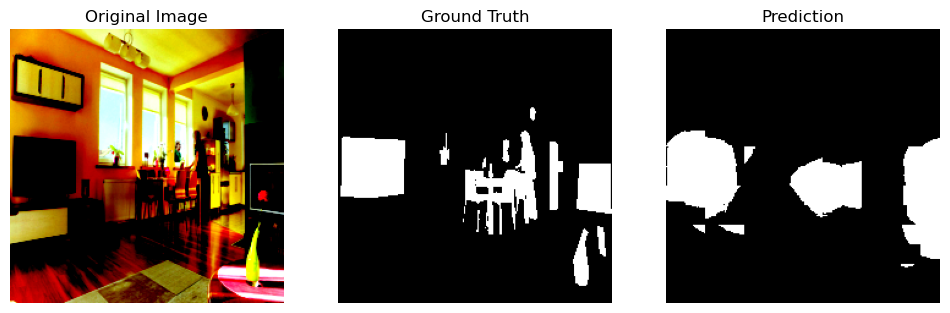

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.64].


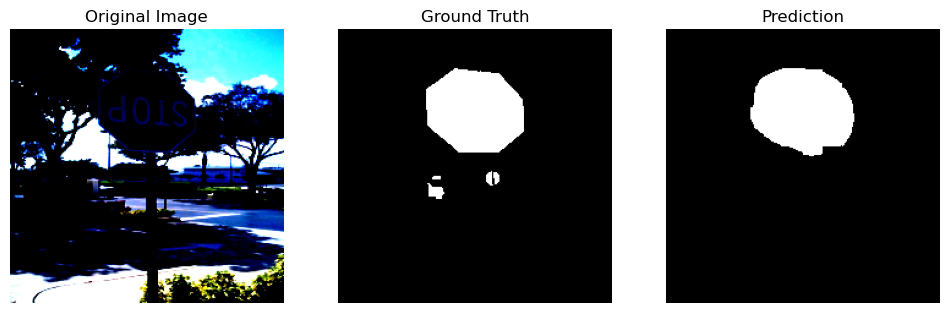

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.3785625].


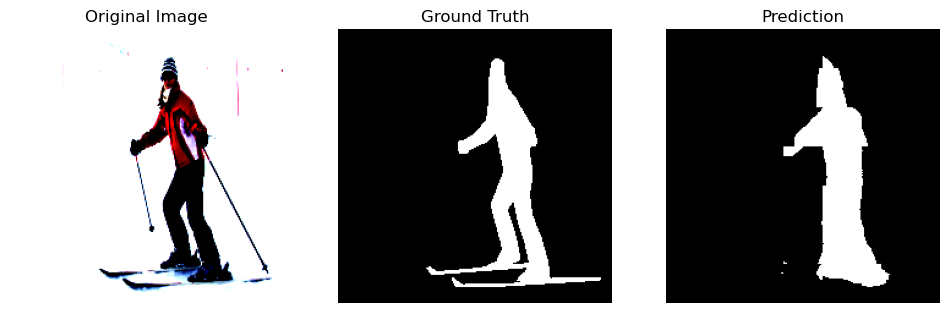

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


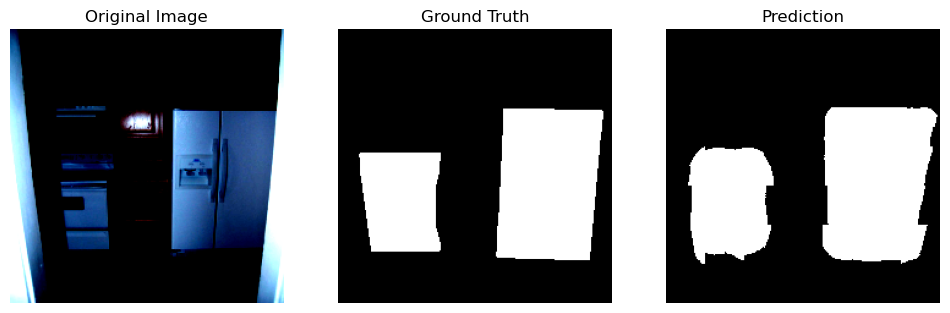

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.5877128].


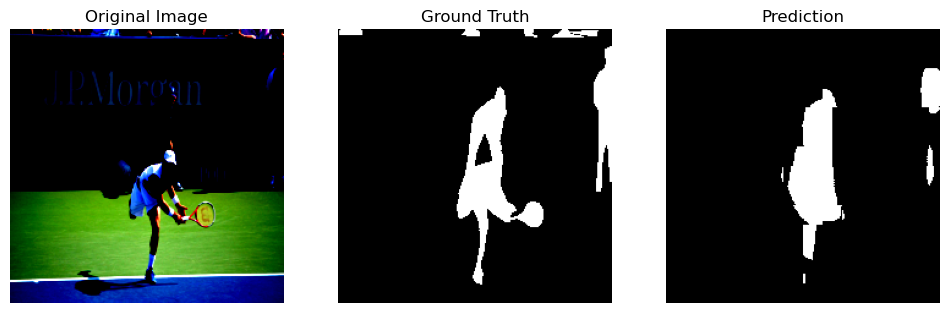

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


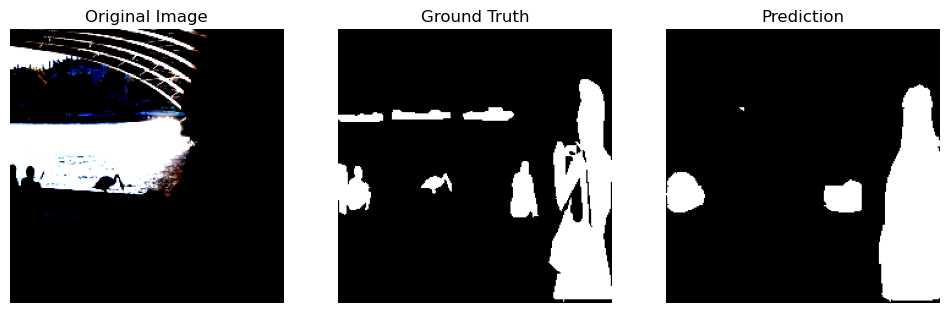

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.7522904].


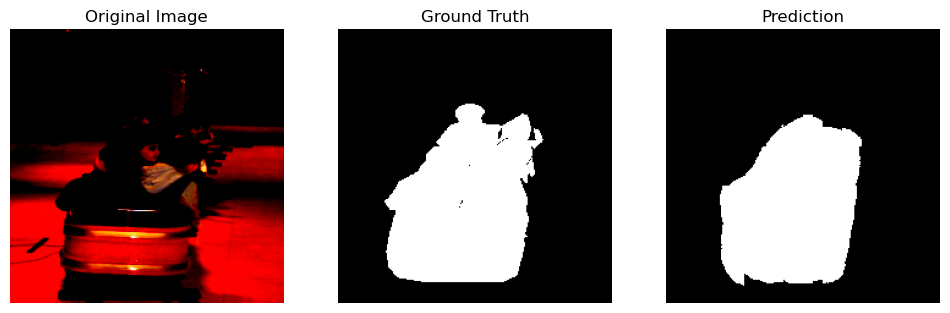

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


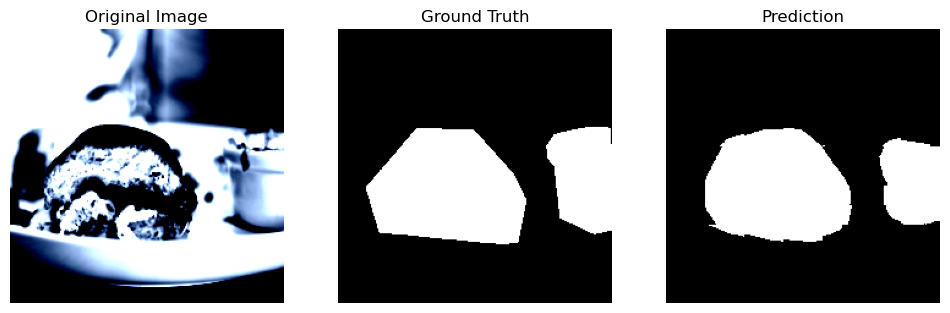

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.622571].


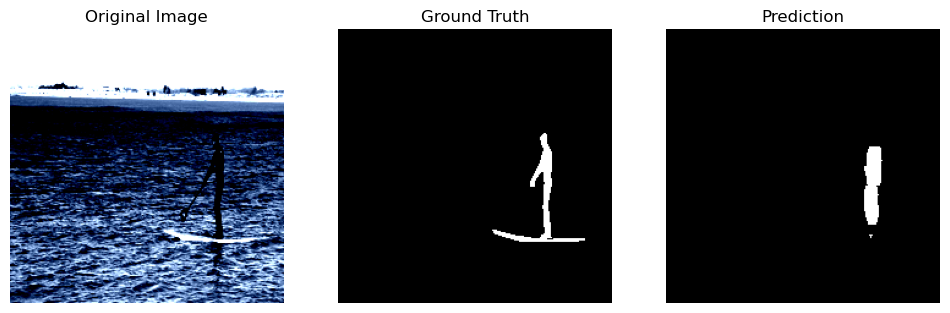

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


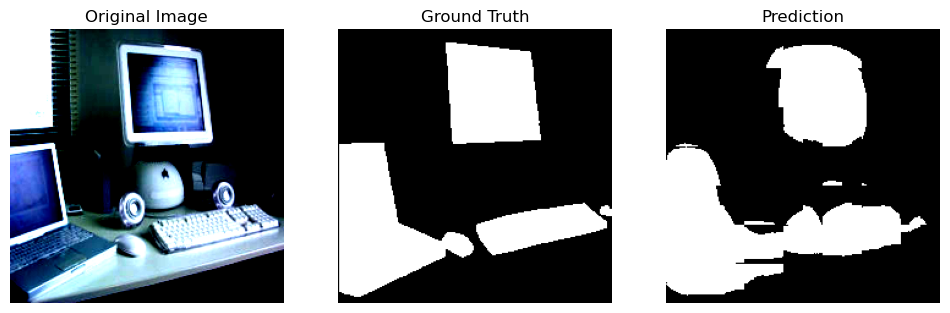

In [16]:
def visualize_predictions(model, dataloader, device, num_images=7):
    model.eval()
    images_shown = 0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)  # convert logits to probs
            preds = (preds > 0.5).float()   # threshold at 0.5
            
            batch_size = images.size(0)
            for i in range(batch_size):
                if images_shown >= num_images:
                    return  # stop after showing num_images

                # Convert tensors for plotting
                img = images[i].permute(1, 2, 0).cpu().numpy()
                gt_mask = masks[i].squeeze().cpu().numpy()
                pred_mask = preds[i].squeeze().cpu().numpy()

                # Plot original, GT, and Prediction
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 3, 1)
                plt.imshow(img)
                plt.title("Original Image")
                plt.axis("off")
                
                plt.subplot(1, 3, 2)
                plt.imshow(gt_mask, cmap="gray")
                plt.title("Ground Truth")
                plt.axis("off")
                
                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask, cmap="gray")
                plt.title("Prediction")
                plt.axis("off")
                
                plt.show()
                
                images_shown += 1
visualize_predictions(model, val_loader, device, num_images=10)